In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd, YearEnd
import datetime as dt
import matplotlib.pyplot as plt
import os
os.chdir("/Users/charlesrambo/Desktop/QIII/Quantitative Asset Management")

In [2]:
# Load stock information
stocks = pd.read_csv("stocks.csv")

In [3]:
# Record CRSP unkowns
unknowns = ["-66.0", "-77.0", "-88.0", "-99.0", "-99.99", "-999", "A", "B", "C", "D", "E", "S", "T", "P"]

# Create function to convert CRISP unkowns to np.nan
convert_unknows = lambda x: np.nan if x in unknowns else x

In [4]:
# Convert date column to date-time object
stocks['date'] = pd.to_datetime(stocks['date'], format = '%Y%m%d')

# Record observations where both returns and delisting returns are missing
stocks['flag'] = stocks['RET'].isna() & stocks['DLRET'].isna()

# Fill missing returns with 0
stocks['RET'] = stocks['RET'].apply(convert_unknows).astype(float).fillna(0)

# Fill missing delisting returns with 0
stocks['DLRET'] = stocks['DLRET'].apply(convert_unknows).astype(float).fillna(0)

# Compute log returns of the product
stocks['RET'] = np.log((1 + stocks['RET']) * (1 + stocks['DLRET']))

#Make stale prices positive
stocks['PRC'] = stocks['PRC'].abs()

# Remove 0 priced observations
stocks = stocks.loc[stocks['PRC'] > 0]

# Remove non-psitive shares outstanding
stocks = stocks.loc[stocks['SHROUT'] > 0]

# Only consider stocks listed on the big exchanges
stocks = stocks.loc[stocks['SHRCD'].isin([10, 11]) & stocks['EXCHCD'].isin([1, 2, 3])]

# Drop unneeded columns
stocks.drop(['DLRET', 'SHRCD', 'EXCHCD', 'PERMCO'], axis = 1, inplace = True)

/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
# Calculate market equity
stocks['ME'] = stocks['PRC'] * stocks['SHROUT']

# Short values for shift
stocks.sort_values(by = ['PERMNO', 'date'], inplace = True)

# Record the shifts which are valid
stocks['Isvalid'] = stocks['date'] + MonthEnd(0) == stocks['date'].shift(1) + dt.timedelta(days = 7) + MonthEnd(0)
stocks.loc[stocks['Isvalid'] == True, 'Isvalid'] = stocks.loc[stocks['Isvalid'] == True, 'PERMNO'] == stocks.loc[stocks['Isvalid'] == True, 'PERMNO'].shift(1)

# Shift market equity
stocks['ME_lag'] = stocks[['PERMNO', 'ME']].groupby('PERMNO')['ME'].shift(1)

# Replace the invalids with nan
stocks.loc[stocks['Isvalid'] == False, 'ME_lag'] = np.nan

# Drop unneeded columns
stocks.drop(['ME', 'Isvalid'], axis = 1, inplace = True)

In [6]:
# Sort values again for another shift
stocks.sort_values(by = ['PERMNO', 'date'], inplace = True)

# Check to see if valid
stocks['Isvalid'] = stocks['date'] + MonthEnd(0) == stocks['date'].shift(12) + dt.timedelta(days = 7) + MonthEnd(12)
stocks.loc[stocks['Isvalid'] == True, 'Isvalid'] = stocks.loc[stocks['Isvalid'] == True, 'PERMNO'] == stocks.loc[stocks['Isvalid'] == True, 'PERMNO'].shift(12)

# Calculate momentum signal
stocks['MOM'] = stocks['RET'].shift(2).rolling(11).sum()

# Remove invalid observations
stocks.loc[stocks['Isvalid'] == False, 'MOM'] = np.nan

# Convert infinite returns to na
stocks['RET'] = stocks['RET'].replace([np.inf, -np.inf], np.nan)

# Remove observations with missing momentum signal
stocks = stocks.loc[stocks['MOM'].notna() & ~stocks['flag'], :]

# Place firms into deciles based on momentum signal
stocks['decile'] = stocks[['date', 'MOM']].groupby('date').transform(lambda x: pd.qcut(x, 10, labels = False))

# Drop uneeded columns
stocks.drop(['Isvalid', 'PRC', 'SHROUT', 'PERMNO', 'MOM', 'flag'], axis = 1, inplace = True)

In [7]:
# Compute weights for returns; value weighted
stocks['wt'] = stocks.groupby(['date', 'decile'])['ME_lag'].transform('sum')
stocks['wt'] = stocks['ME_lag']/stocks['wt']

# Weight returns
stocks['RET'] = stocks['RET'] * stocks['wt']

# Compute sume
W = stocks[['date', 'decile', 'RET']].groupby(['date', 'decile'])['RET'].sum().reset_index()

# Add 1 to deciles to avoid confusion
W['decile'] = 1 + W['decile']

# Undo log return calculate
W['RET'] = W['RET'].apply(np.exp) - 1

W.head()

,date,decile,RET
0,1974-12-31,1,-0.057489
1,1974-12-31,2,-0.047717
2,1974-12-31,3,-0.071430
3,1974-12-31,4,-0.037651
4,1974-12-31,5,-0.040343


In [8]:
# Make each decile its own column
deciles = W.pivot(index = 'date', columns = 'decile', values = 'RET').reset_index()

# Calculate winners minus losers
deciles['wml'] = deciles[10] - deciles[1]

deciles.head()

decile,date,1,2,3,4,5,6,7,8,9,10,wml
0,1974-12-31,-0.057489,-0.047717,-0.071430,-0.037651,-0.040343,-0.022080,-0.021311,-0.018940,0.004415,-0.036807,0.020683
1,1975-01-31,0.298759,0.280975,0.185028,0.112457,0.147705,0.104635,0.071509,0.092411,0.124303,0.112269,-0.186490
2,1975-02-28,0.052432,0.066288,0.063239,0.030882,0.097922,0.034669,0.066664,0.058126,0.050050,0.035779,-0.016653
3,1975-03-31,0.082226,0.056961,0.023014,0.047053,0.029042,0.013761,0.021114,-0.001186,0.040525,0.070834,-0.011392
4,1975-04-30,0.025278,0.047257,0.067493,0.033242,0.060814,0.052070,0.026981,0.039376,0.025009,0.072989,0.047711


In [9]:
stats = pd.DataFrame(index = deciles.columns[1:])

# Take a look at the mean
stats['mean'] = deciles.mean()

# Take a look at the sd
stats['sd'] = deciles.std()

# Take a look at the skew
stats['skew'] = deciles.skew()

stats

,mean,sd,skew
decile,,,
1,-0.010669,0.094376,0.364164
2,-0.001330,0.071832,-0.255874
3,0.004277,0.061145,-0.149047
4,0.006855,0.050992,-0.336989
5,0.008173,0.047060,-0.411477
6,0.007505,0.043465,-0.506360
7,0.009008,0.043080,-0.613381
8,0.009998,0.045753,-0.585472
9,0.009703,0.050553,-0.740854


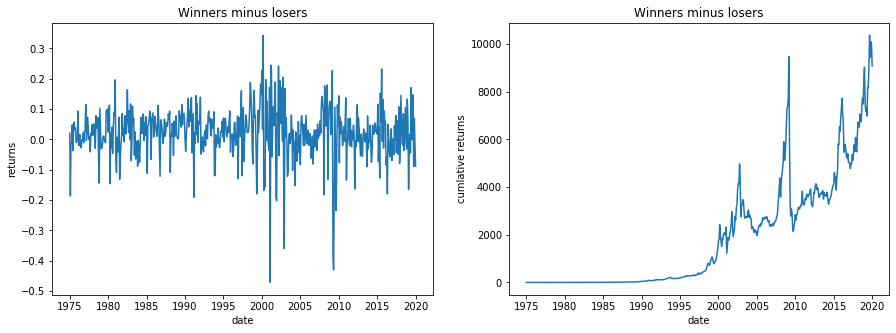

In [10]:
# Plot returns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
ax1.plot(deciles['date'], deciles["wml"])
ax1.set_xlabel('date') 
ax1.set_ylabel('returns') 
ax1.set_title('Winners minus losers') 

ax2.plot(deciles['date'], (1 + deciles["wml"]).cumprod() - 1) 
ax2.set_xlabel('date') 
ax2.set_ylabel('cumlative returns') 
ax2.set_title('Winners minus losers') 

plt.show()

In [11]:
# Load Daniel's momentum
daniel = pd.read_csv("m_m_pt_tot.csv", header = None)
daniel.rename(columns = {0:"date", 1:"decile", 2:"ret", 3:"avg_me", 4:"firms"}, inplace = True)
daniel['date'] = pd.to_datetime(daniel['date'], format = '%Y%m%d')
daniel.drop(['avg_me', 'firms'], axis = 1, inplace = True)

daniel = daniel.pivot(index = 'date', columns = 'decile', values = 'ret').reset_index()
daniel['wml'] = daniel[10] - daniel[1]

daniel.head()

decile,date,1,2,3,4,5,6,7,8,9,10,wml
0,1927-01-31,-0.03362,-0.04584,0.02755,-0.00319,-0.00294,0.00893,0.00781,0.00359,-0.00375,-0.00225,0.03137
1,1927-02-28,0.07627,0.05984,0.08206,0.07271,0.03510,0.03040,0.04012,0.03257,0.04169,0.07007,-0.00620
2,1927-03-31,-0.03003,-0.03055,-0.03914,-0.04880,-0.00540,-0.02391,0.02067,0.00850,-0.00034,0.06091,0.09094
3,1927-04-30,0.02042,-0.03130,-0.02379,-0.01262,0.01977,-0.00058,0.02094,-0.00930,0.01809,0.05489,0.03447
4,1927-05-31,0.03949,0.04313,0.06097,0.03178,0.06337,0.05800,0.05219,0.06671,0.08051,0.06231,0.02282


In [12]:
# See correlation; not perfect because momentum construction (intentionally) not exactly same
results = deciles.merge(daniel, on = 'date')

round(results.corr().iloc[0:11 , 11:], 3)

decile,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,wml_y
decile,,,,,,,,,,,
1_x,0.986,0.912,0.863,0.804,0.761,0.714,0.621,0.577,0.522,0.495,-0.729
2_x,0.875,0.979,0.921,0.871,0.831,0.793,0.687,0.636,0.569,0.497,-0.603
3_x,0.841,0.921,0.989,0.922,0.884,0.840,0.729,0.672,0.583,0.491,-0.570
4_x,0.783,0.865,0.908,0.989,0.919,0.886,0.805,0.748,0.629,0.521,-0.482
5_x,0.736,0.819,0.869,0.906,0.992,0.918,0.862,0.819,0.727,0.604,-0.366
6_x,0.680,0.768,0.827,0.880,0.907,0.994,0.920,0.895,0.796,0.669,-0.253
7_x,0.606,0.667,0.728,0.800,0.857,0.915,0.997,0.935,0.865,0.732,-0.121
8_x,0.552,0.614,0.669,0.737,0.814,0.893,0.934,0.997,0.904,0.783,-0.022
9_x,0.516,0.550,0.586,0.633,0.723,0.793,0.864,0.907,0.997,0.883,0.094
